In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz

In [2]:
az.style.use("arviz-grayscale")
from cycler import cycler

default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
plt.rc("axes", prop_cycle=default_cycler)
plt.rc("figure", dpi=300)
np.random.seed(123)

In [3]:
def posterior_grid(grid_points=50, heads=6, tails=9):
    """ 
    A grid implementation for the coin-flipping problem 
    """
    grid = np.linspace(0, 1, grid_points)
    prior = np.repeat(1/grid_points, grid_points)  # uniform prior
    likelihood = pz.Binomial(n=heads+tails, p=grid).pdf(heads)
    posterior = likelihood * prior
    posterior /= posterior.sum() * (1/grid_points)
    return grid, posterior

Assuming we flip a coin 13 times and we observed 3 head we have:

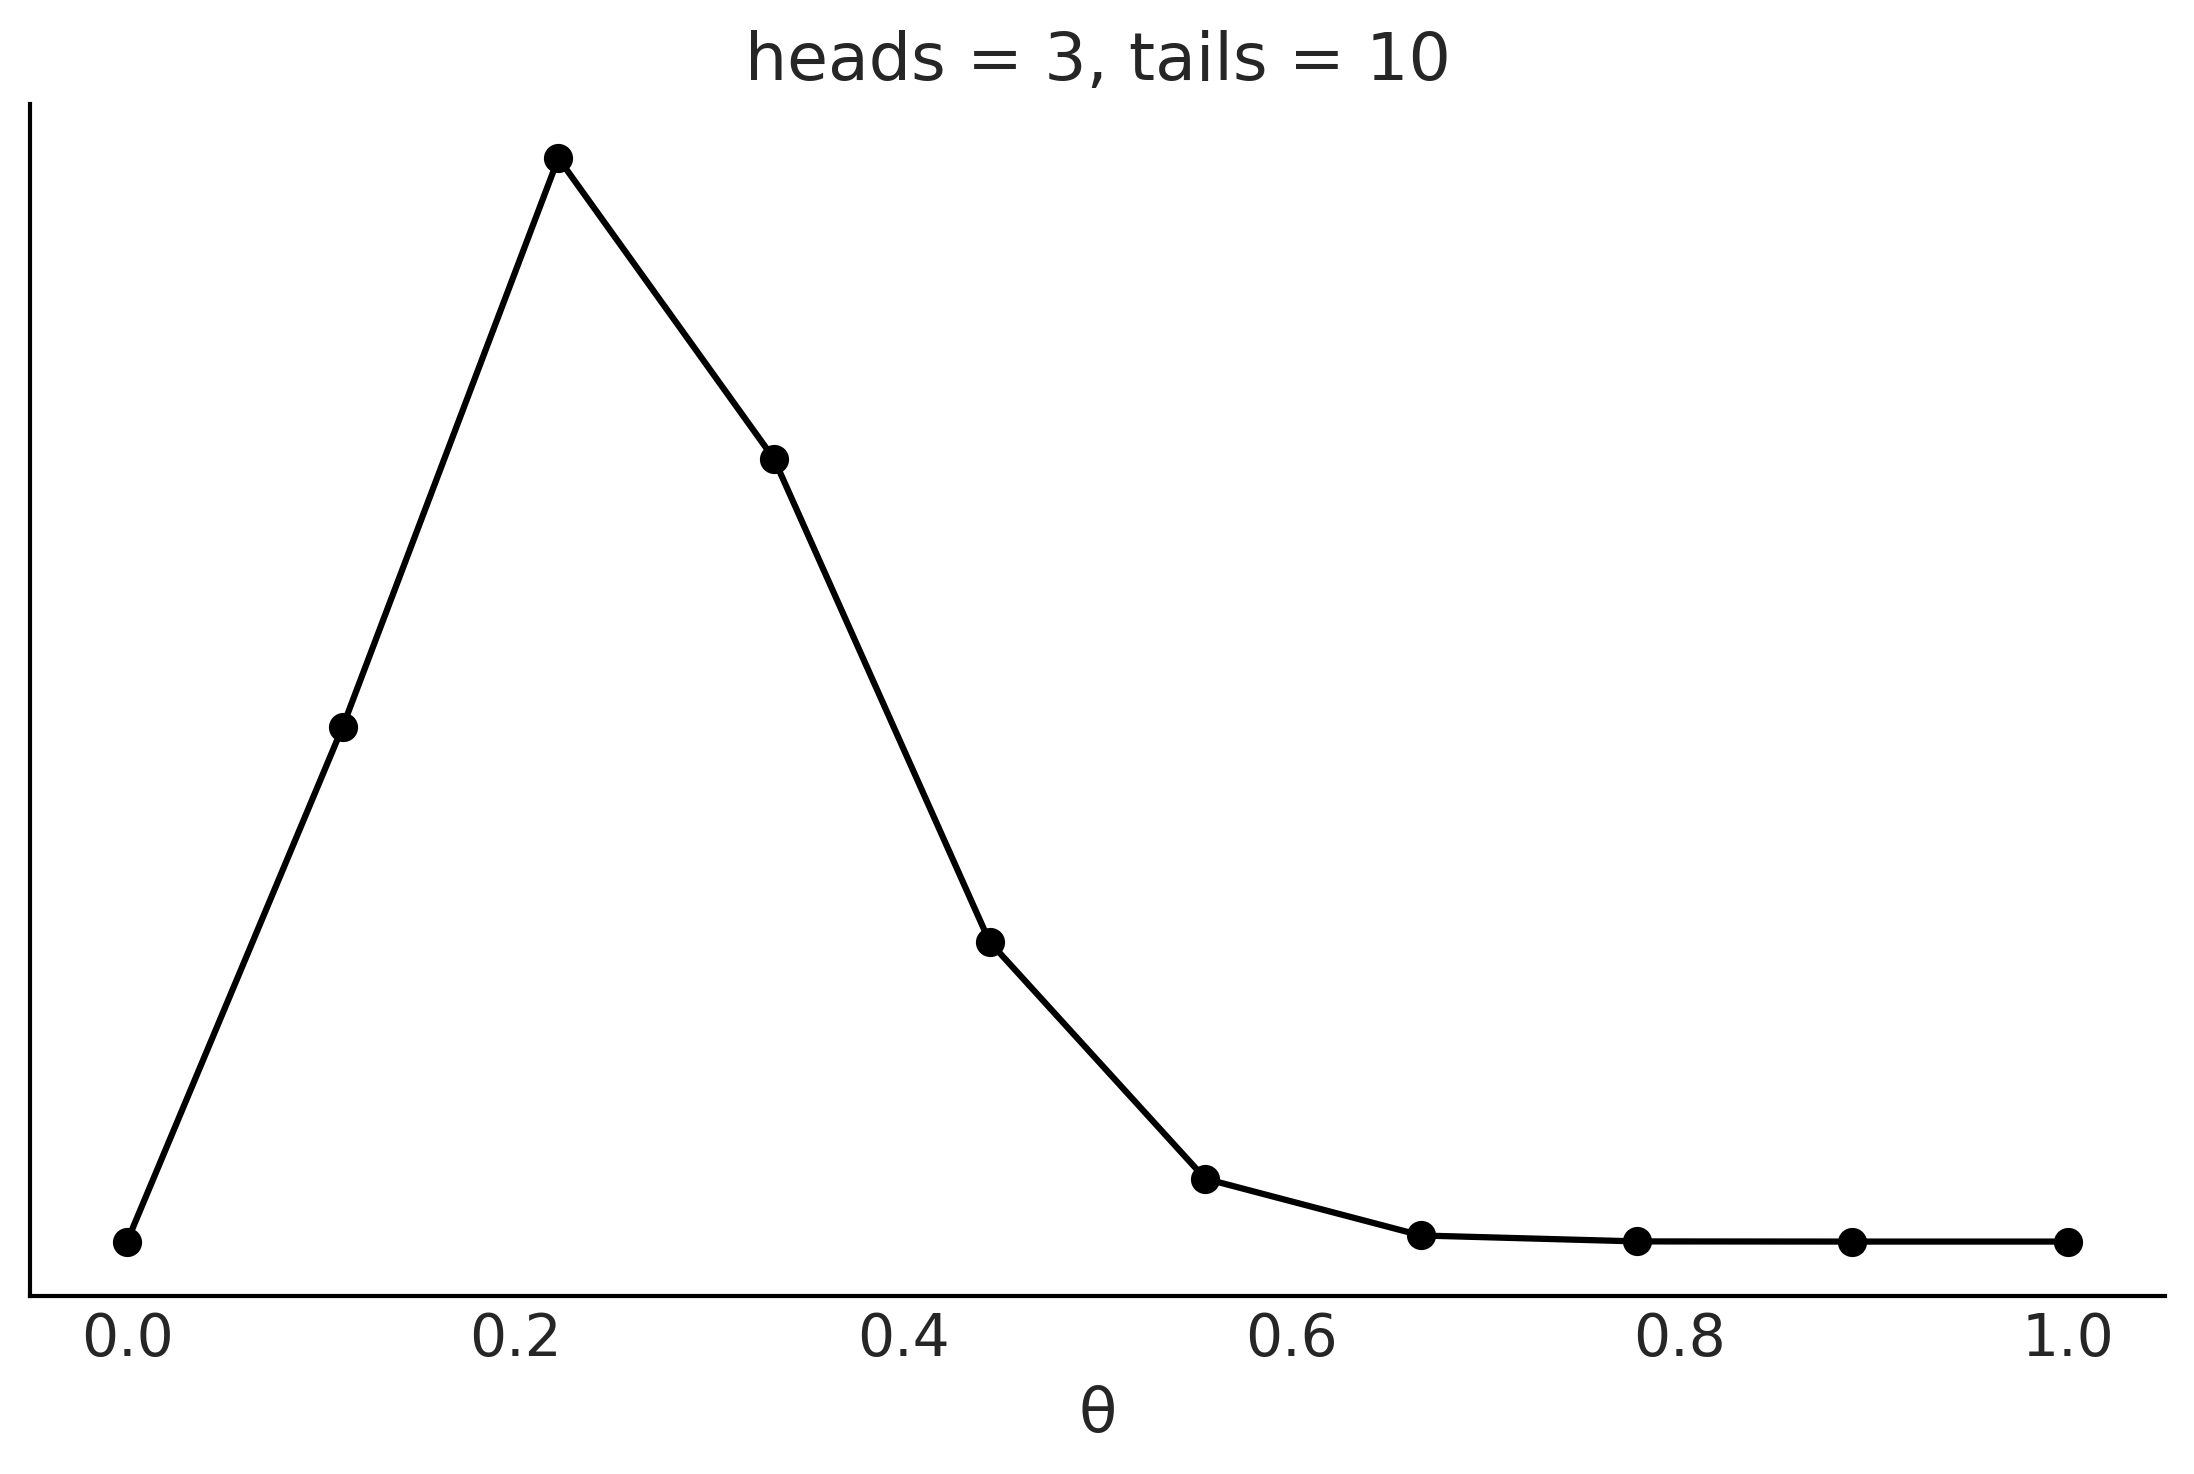

In [4]:
data = np.repeat([0, 1], (10, 3))
points = 10
h = data.sum()
t = len(data) - h
grid, posterior = posterior_grid(points, h, t) 

plt.plot(grid, posterior, 'o-')

plt.title(f'heads = {h}, tails = {t}')
plt.yticks([])
plt.xlabel('θ');
plt.savefig('../fig/grid_coin_flipping.png')

### Quadratic method

In [5]:
data = pd.DataFrame(data, columns=["w"])
priors = {"Intercept": bmb.Prior("Uniform", lower=0, upper=1)}
model = bmb.Model("w ~ 1", data=data, family="bernoulli", priors=priors, link="identity")
results = model.fit(draws=4000, inference_method="laplace")

Modeling the probability that w==1


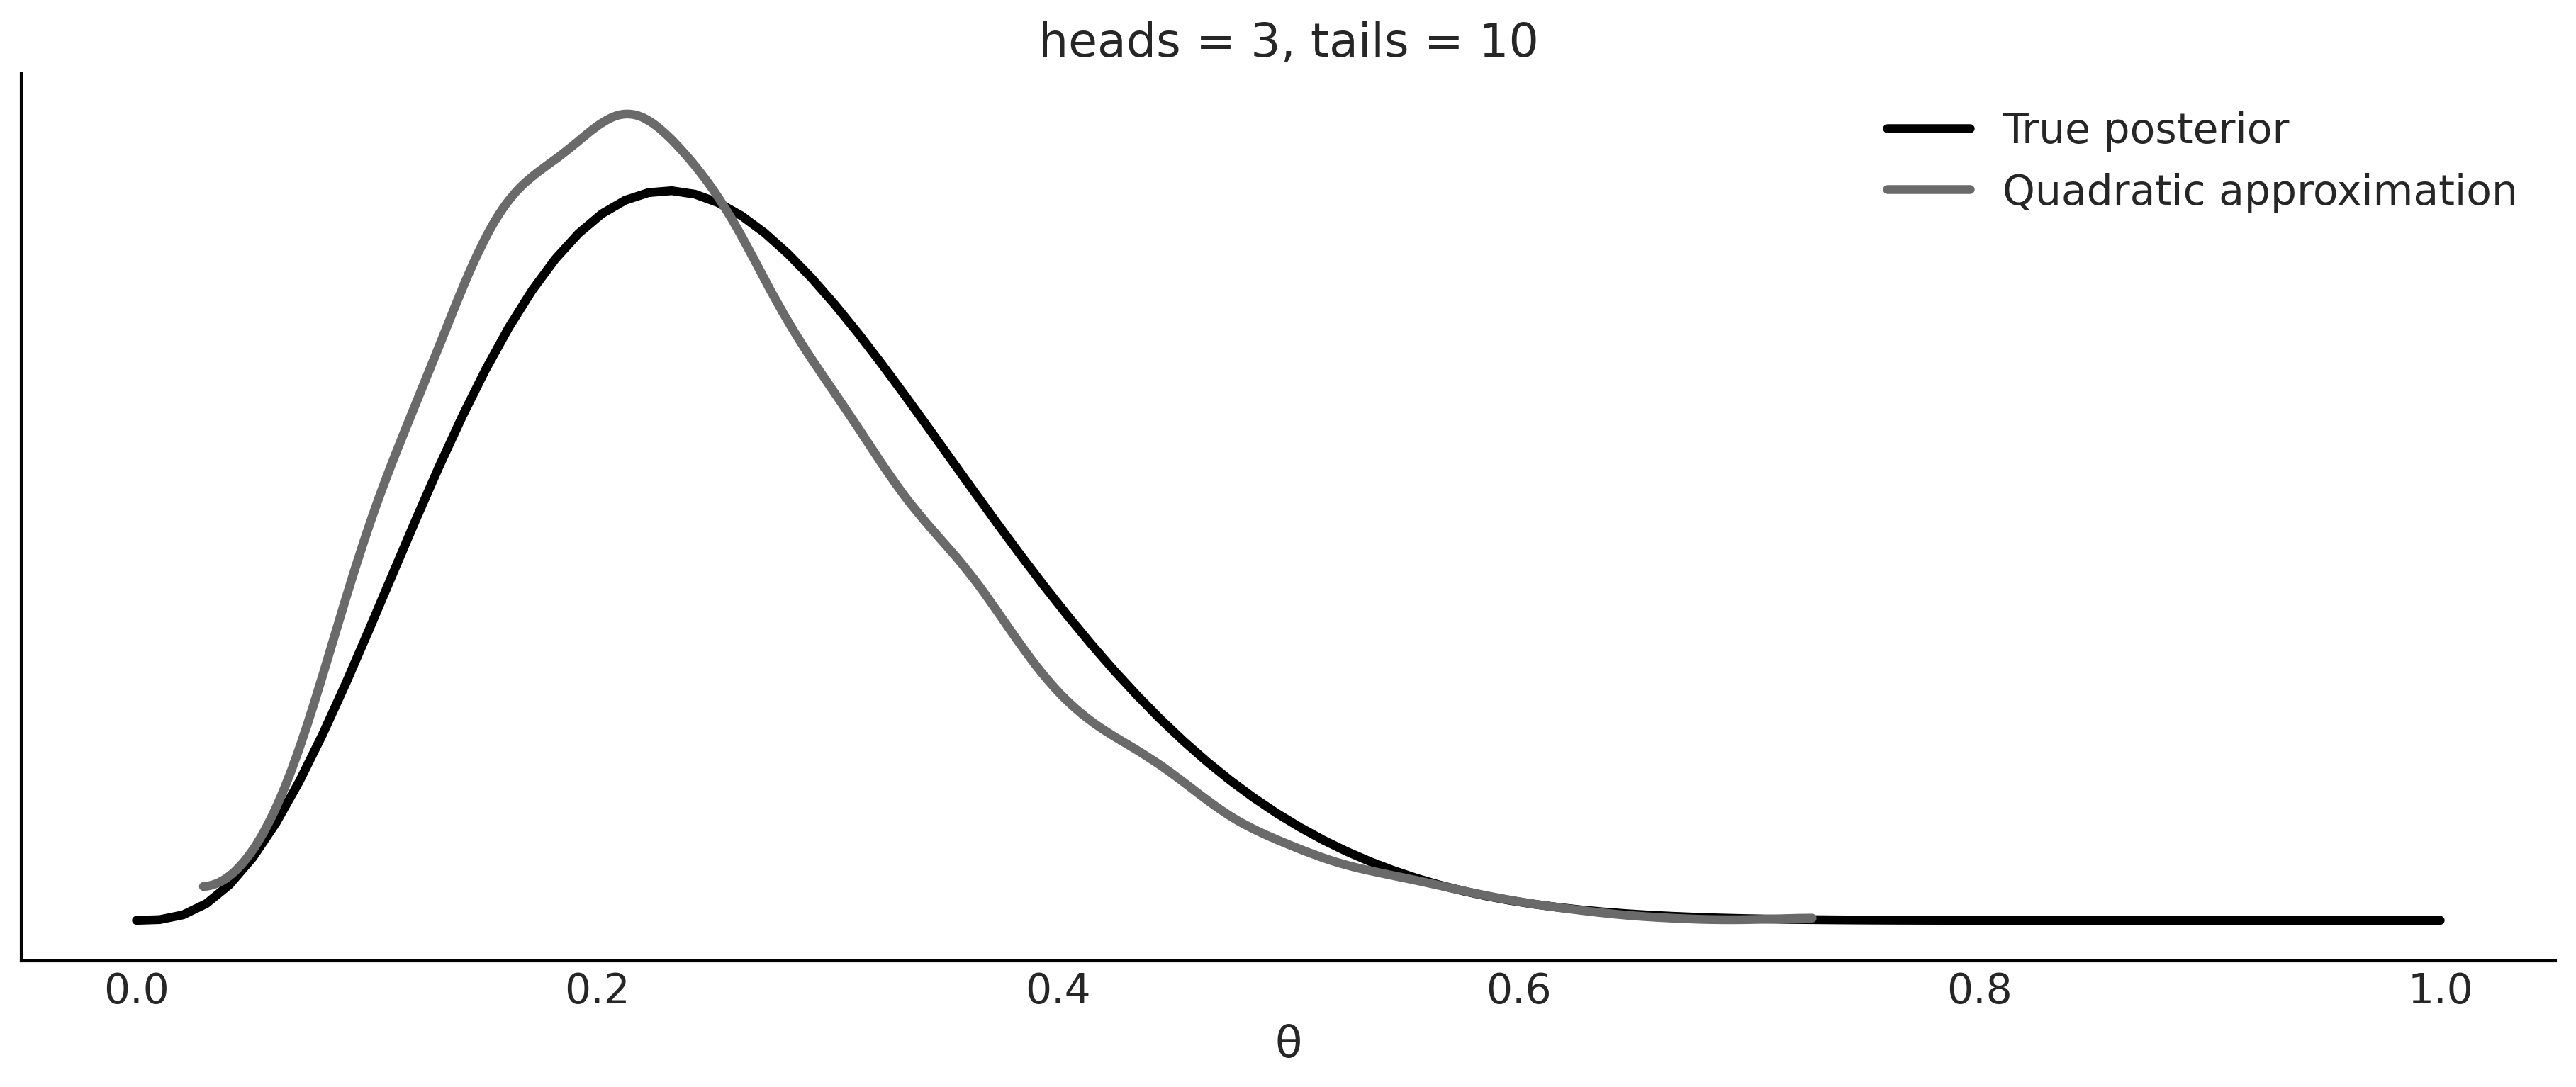

In [6]:
_, ax = plt.subplots(figsize=(12, 5))
# analytical calculation
x = np.linspace(0, 1, 100)
plt.plot(x, pz.Beta(h+1, t+1).pdf(x), label='True posterior', lw=3)

# quadratic approximation
az.plot_kde(results.posterior["Intercept"].values, label='Quadratic approximation',
            ax=ax, plot_kwargs={"color": "C1", "lw": 3})

ax.set_title(f'heads = {h}, tails = {t}')
ax.set_xlabel('θ')
ax.set_yticks([])
plt.savefig('../fig/quadratic.png');

## Markovian methods

### Monte Carlo


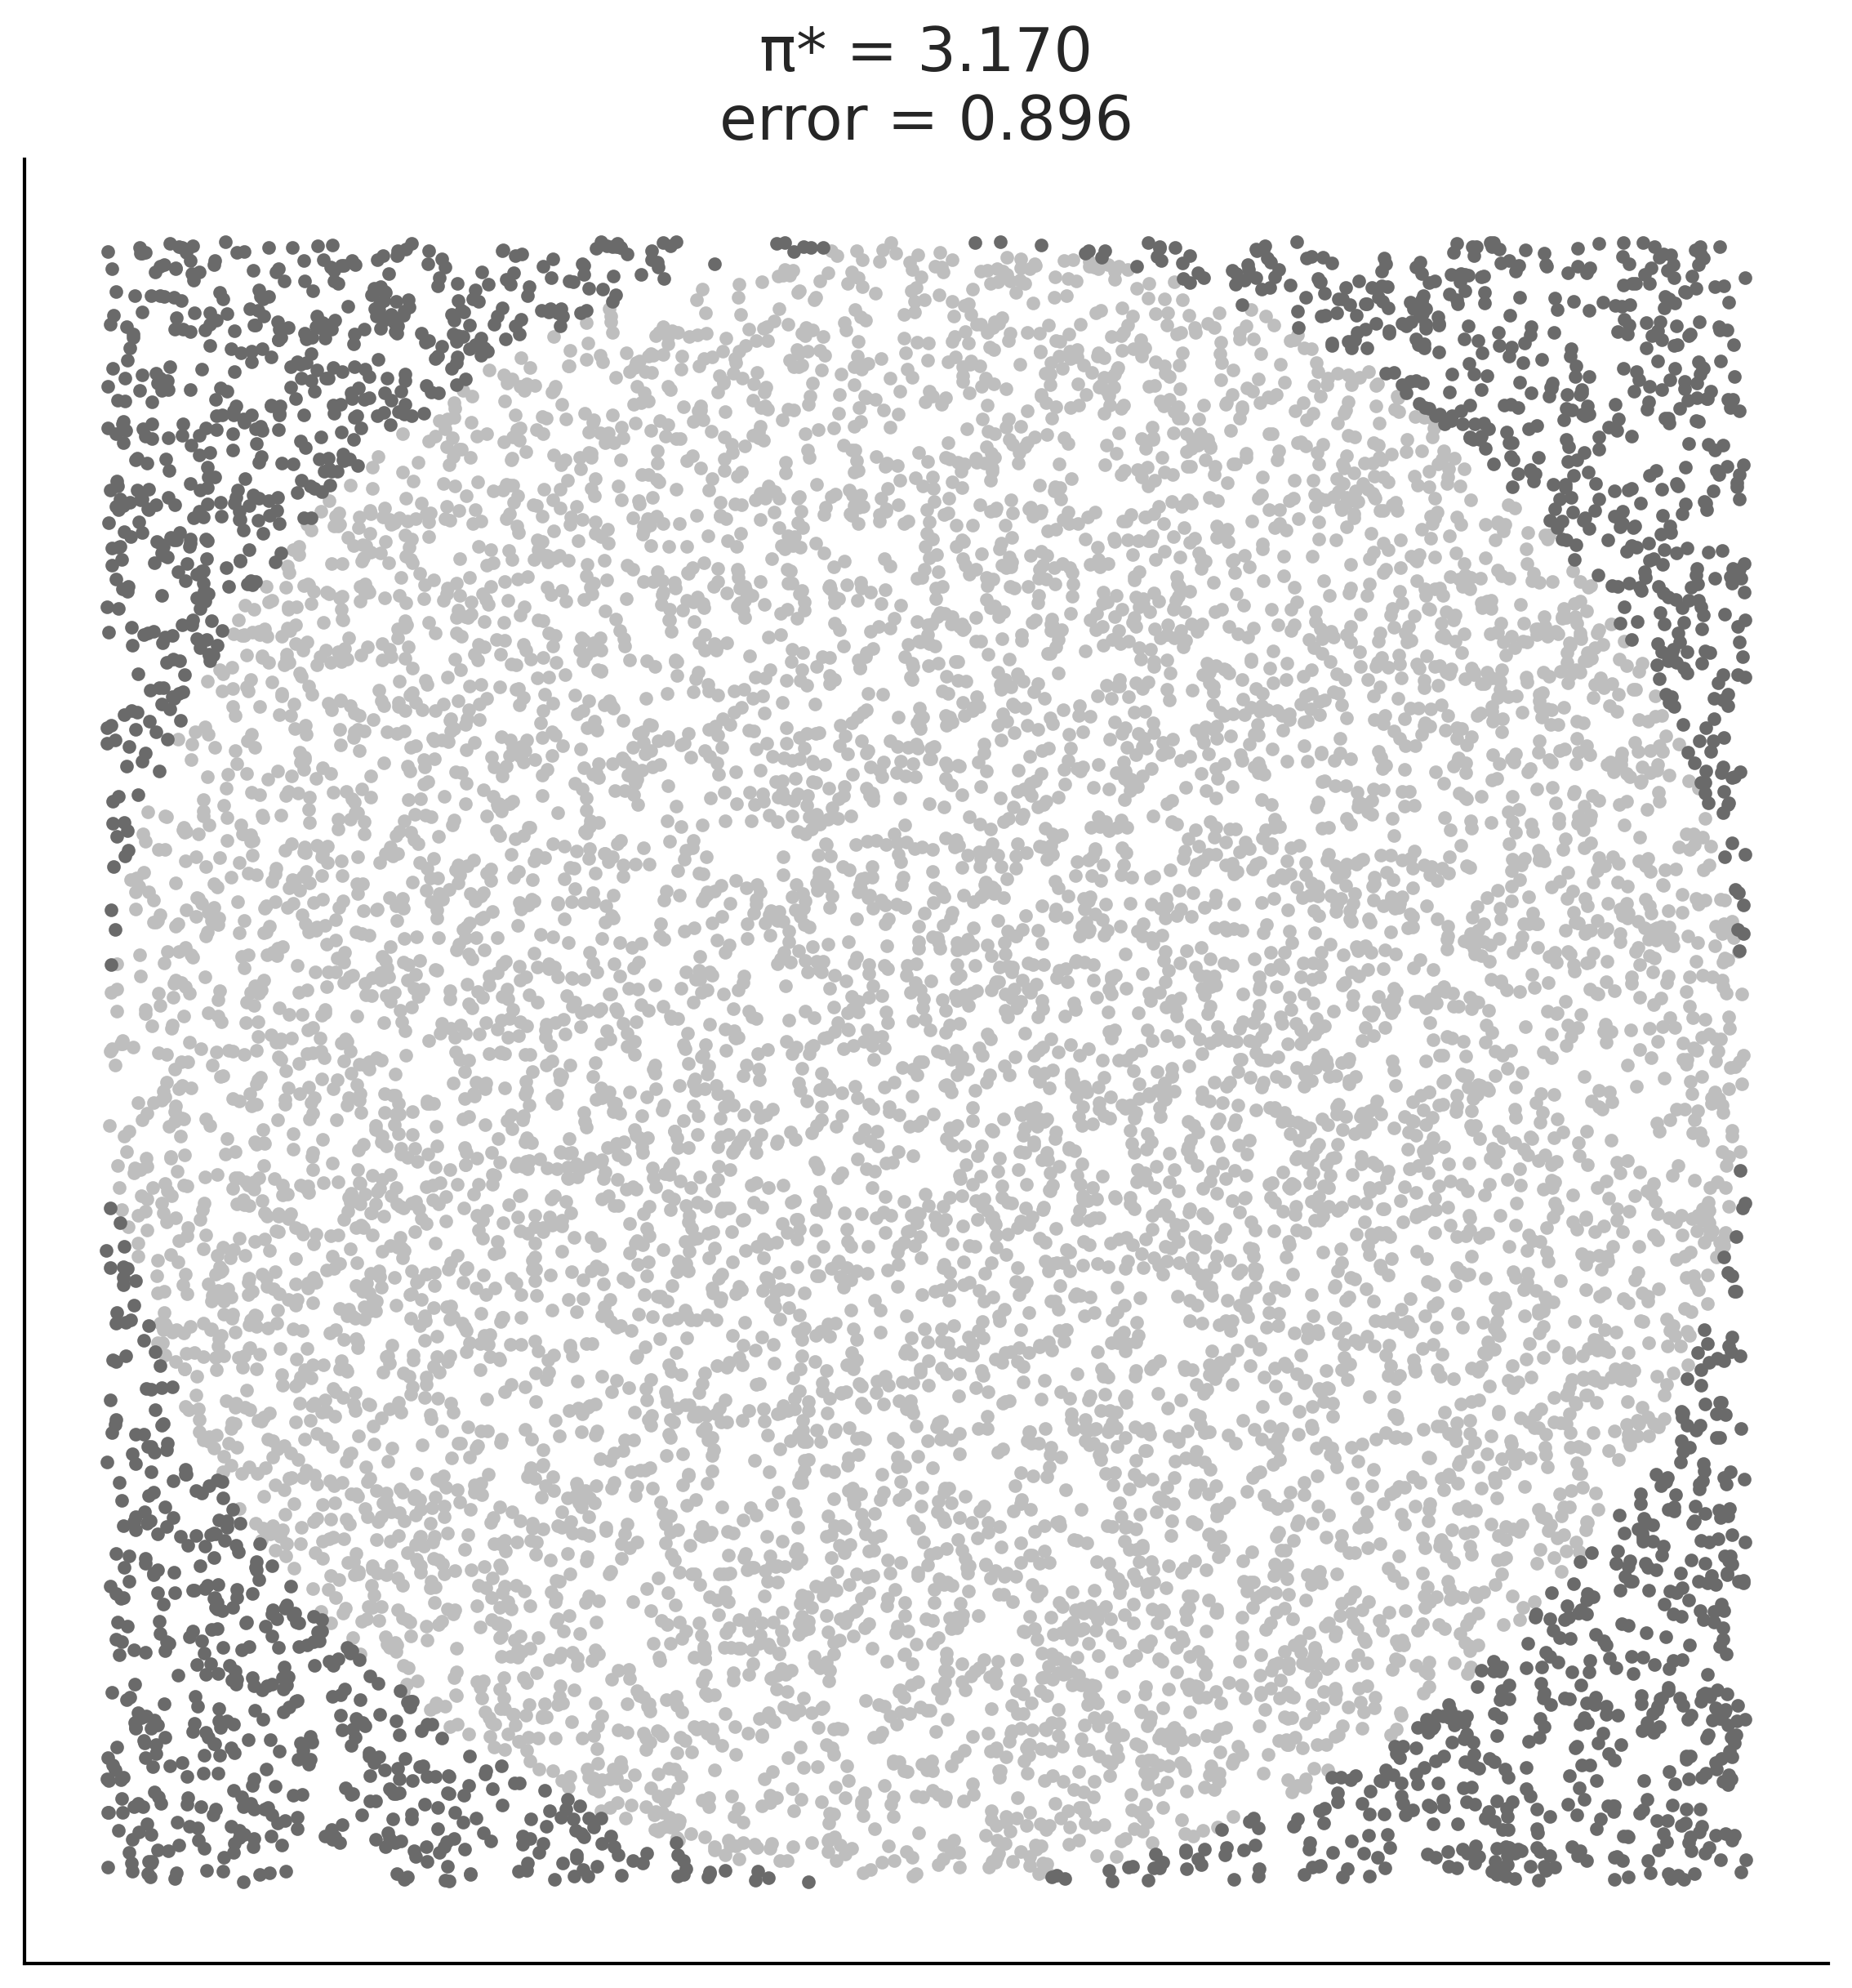

In [7]:
N = 10000

x, y = np.random.uniform(-1, 1, size=(2, N))
inside = (x**2 + y**2) <= 1
pi = inside.sum()*4/N
error = abs((pi - np.pi) / pi) * 100
 
outside = np.invert(inside)
 
_, ax = plt.subplots(figsize=(8, 8))
ax.plot(x[inside], y[inside], 'C2.')
ax.plot(x[outside], y[outside], 'C1.')
ax.axis('square')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(f'π* = {pi:4.3f}\nerror = {error:4.3f}', fontsize=18)
plt.savefig('../fig/pi_monte_carlo.png')

In [8]:
def metropolis(dist, draws=1000):
    """A very simple Metropolis implementation"""
    trace = np.zeros(draws)
    old_x = 0.5
    old_prob = dist.pdf(old_x)

    delta = np.random.normal(0, 0.5, draws)
    for i in range(draws):
        new_x = old_x + delta[i]
        new_prob = dist.pdf(new_x)
        acceptance = new_prob / old_prob
        if acceptance >= np.random.random():
            trace[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else:
            trace[i] = old_x

    return trace

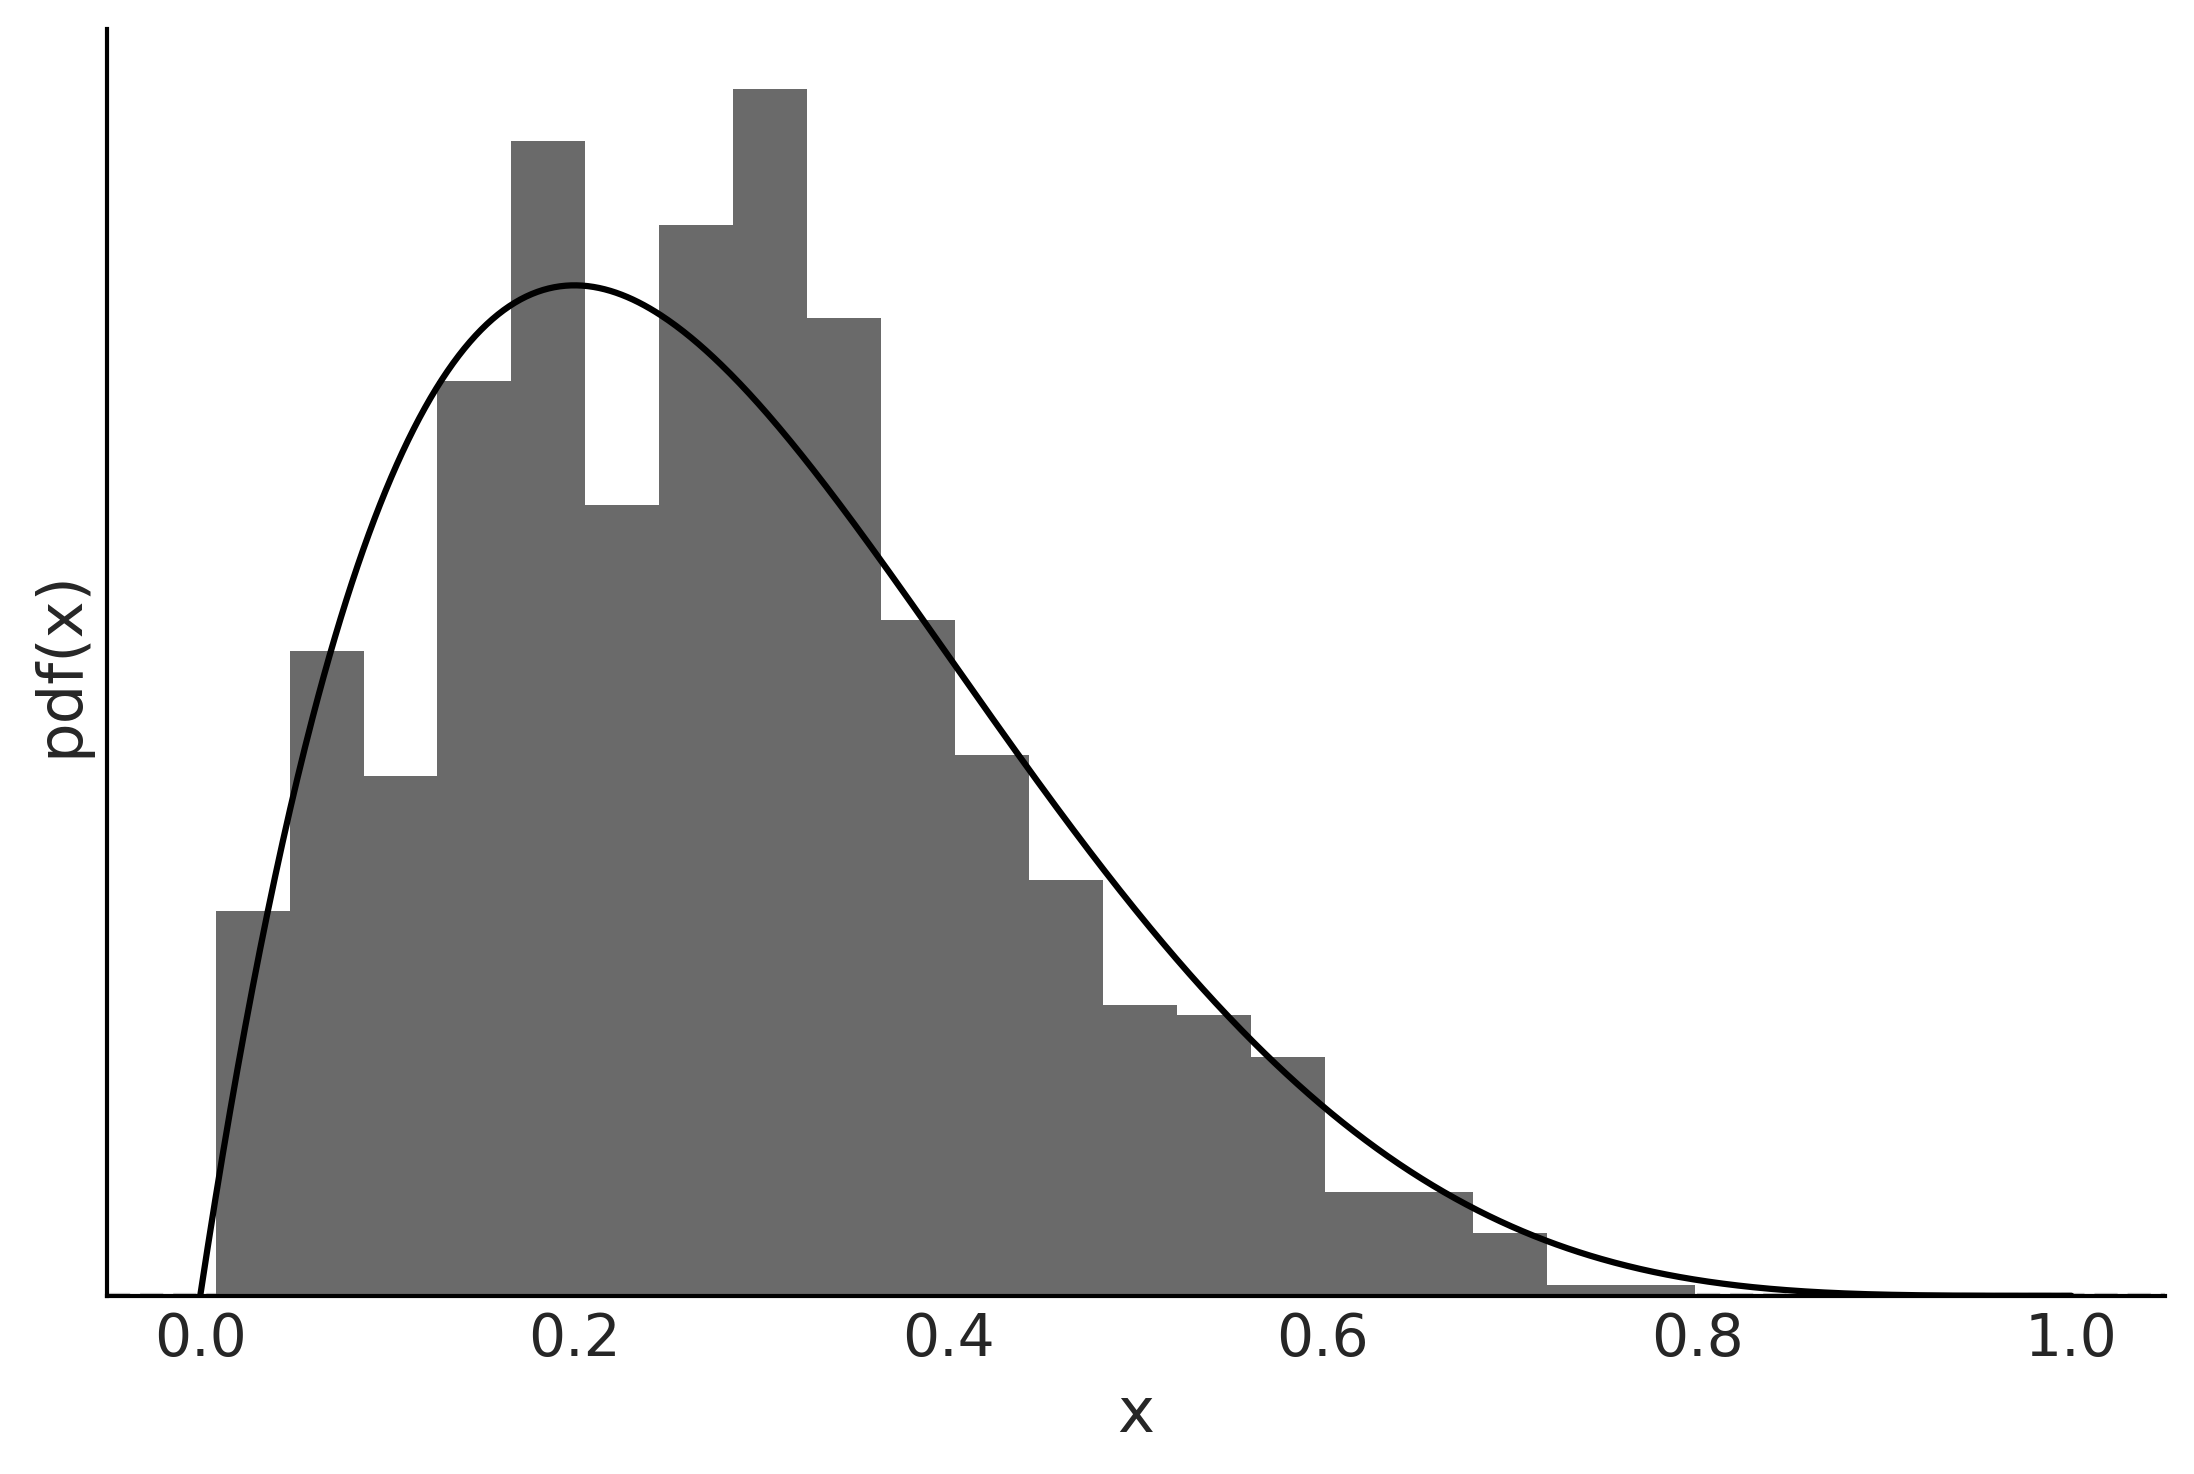

In [9]:
np.random.seed(3)
dist = pz.Beta(2, 5) 
trace = metropolis(dist) 
ax = dist.plot_pdf(legend=False)
ax.hist(trace, bins="auto", density=True, label='Estimated distribution') 
ax.set_xlabel('x') 
ax.set_ylabel('pdf(x)')
plt.savefig('../fig/MH.png')

## Diagnosing the samples

In [10]:
with pm.Model() as model_cm:
    a = pm.HalfNormal('a', 10)
    b = pm.Normal('b', 0, a, shape=10)
    idata_cm = pm.sample(random_seed=73)

with pm.Model() as model_ncm:
    a = pm.HalfNormal('a', 10)

    b_offset = pm.Normal('b_offset', mu=0, sigma=1, shape=10)
    b = pm.Deterministic('b', 0 + b_offset * a)
    idata_ncm = pm.sample(random_seed=73, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [11]:
coords = {'b_dim_0': [0]}

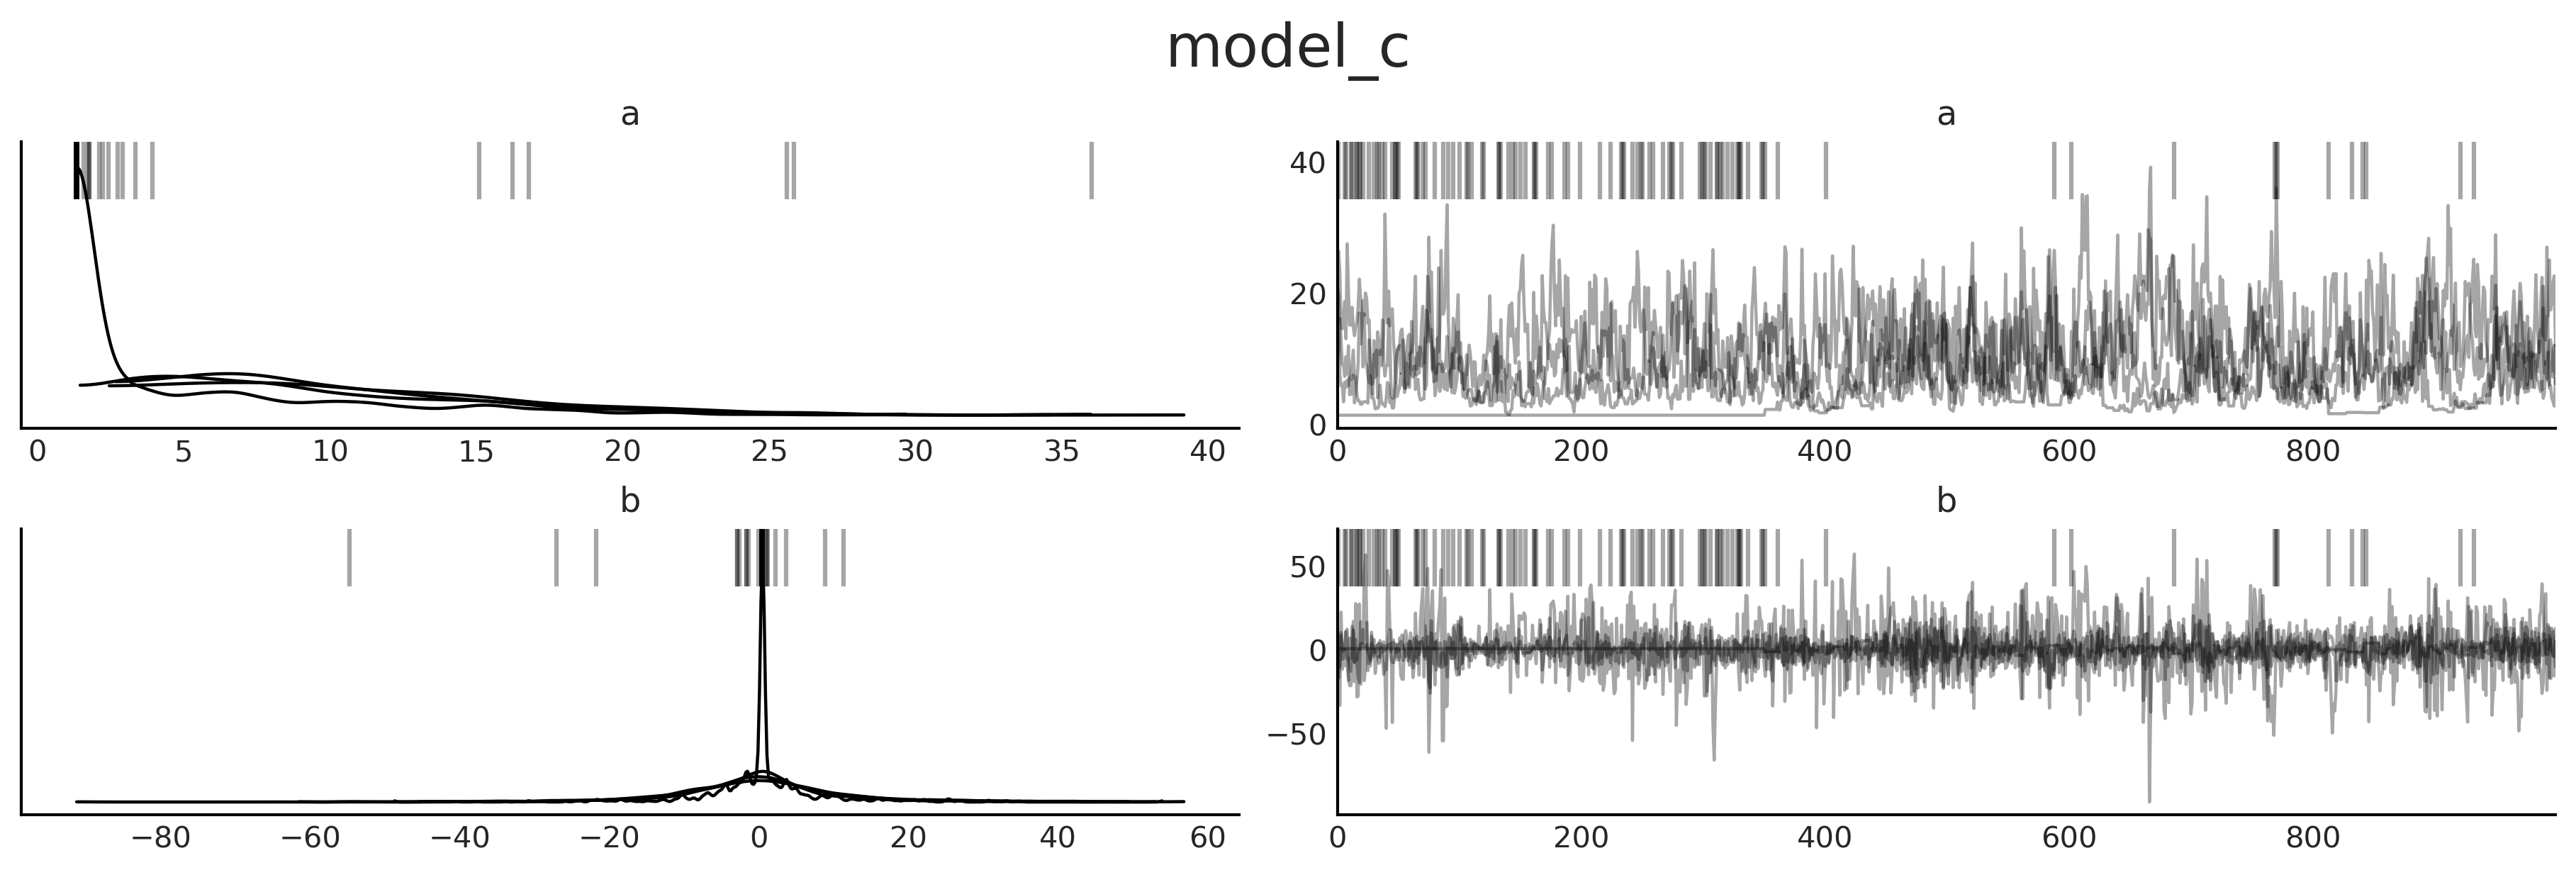

In [12]:
ax = az.plot_trace(idata_cm, var_names=['a', "b"], coords=coords, divergences='top', chain_prop={"ls": "-"})
ax[0, 0].get_figure().suptitle('model_c', fontsize=20)
plt.savefig('../fig/trace_plot_model_c.png')

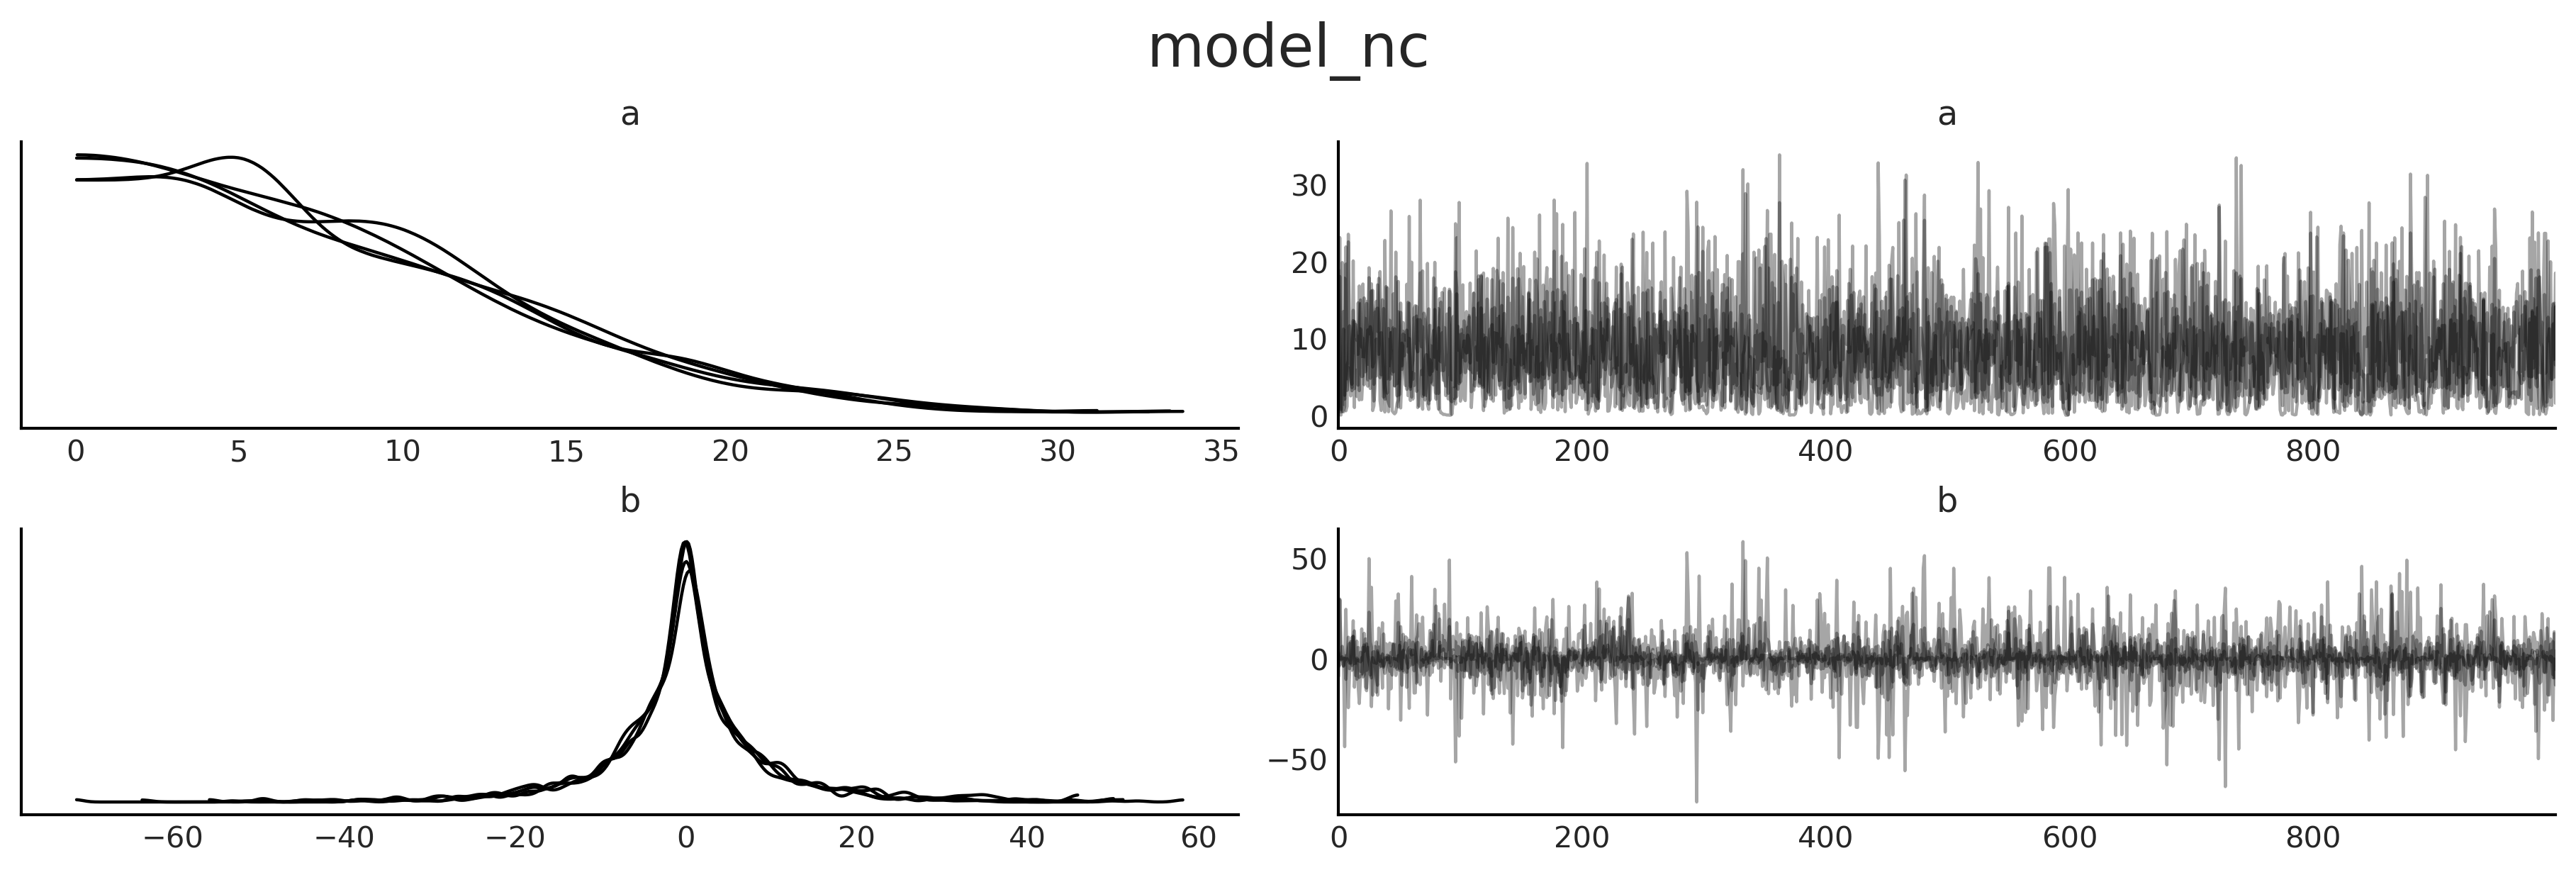

In [13]:
ax = az.plot_trace(idata_ncm, var_names=['a', "b"], divergences='top', coords=coords, chain_prop={"ls": "-"})
ax[0, 0].get_figure().suptitle('model_nc', fontsize=20)
plt.savefig('../fig/trace_plot_model_nc.png')


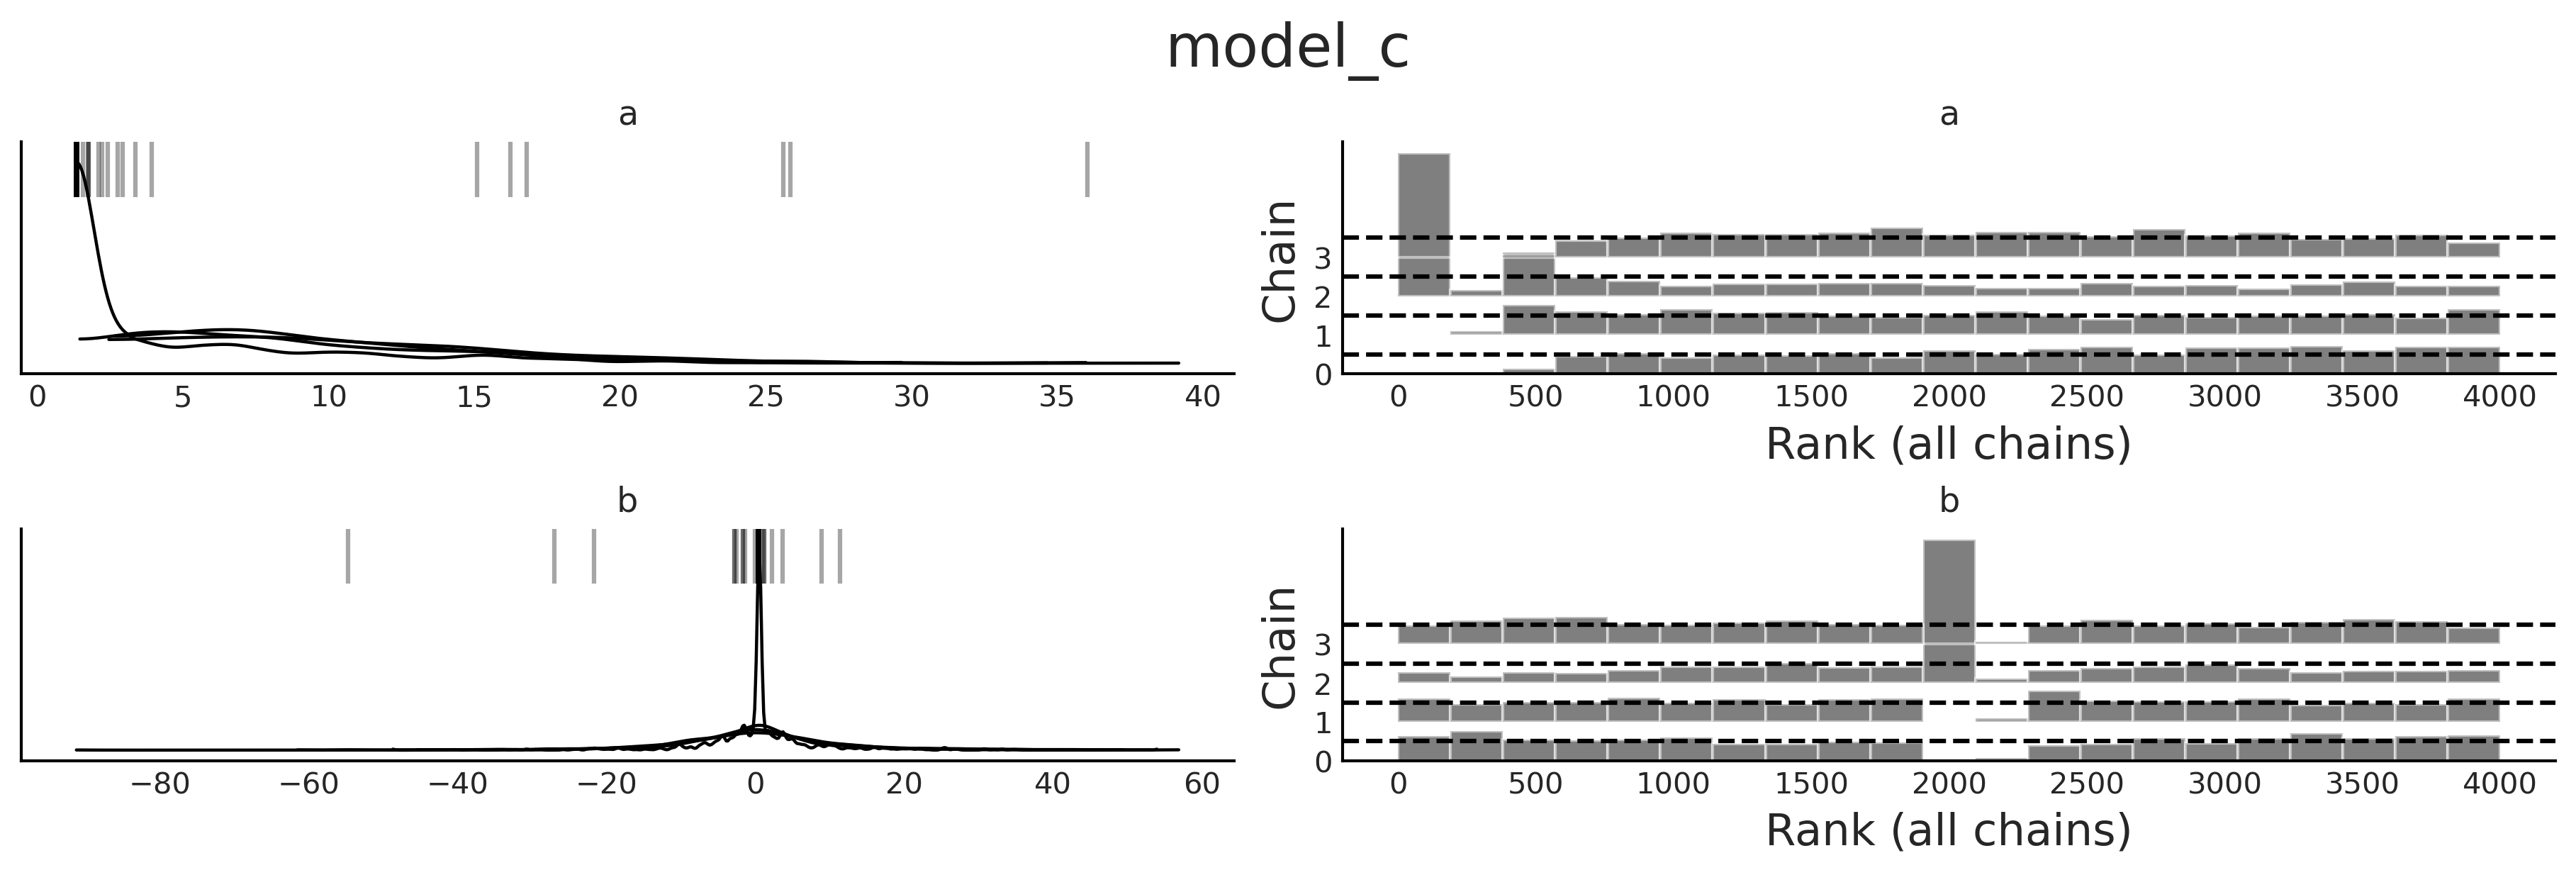

In [14]:
ax = az.plot_trace(idata_cm, var_names=['a', "b"], divergences='top', kind='rank_bars', coords=coords, chain_prop={"ls": "-"},
                   rank_kwargs={"colors": "k", "bar_kwargs": {"alpha": 0.5}})

ax[0, 0].get_figure().suptitle('model_c', fontsize=20)
plt.savefig('../fig/rank_plot_model_c.png')

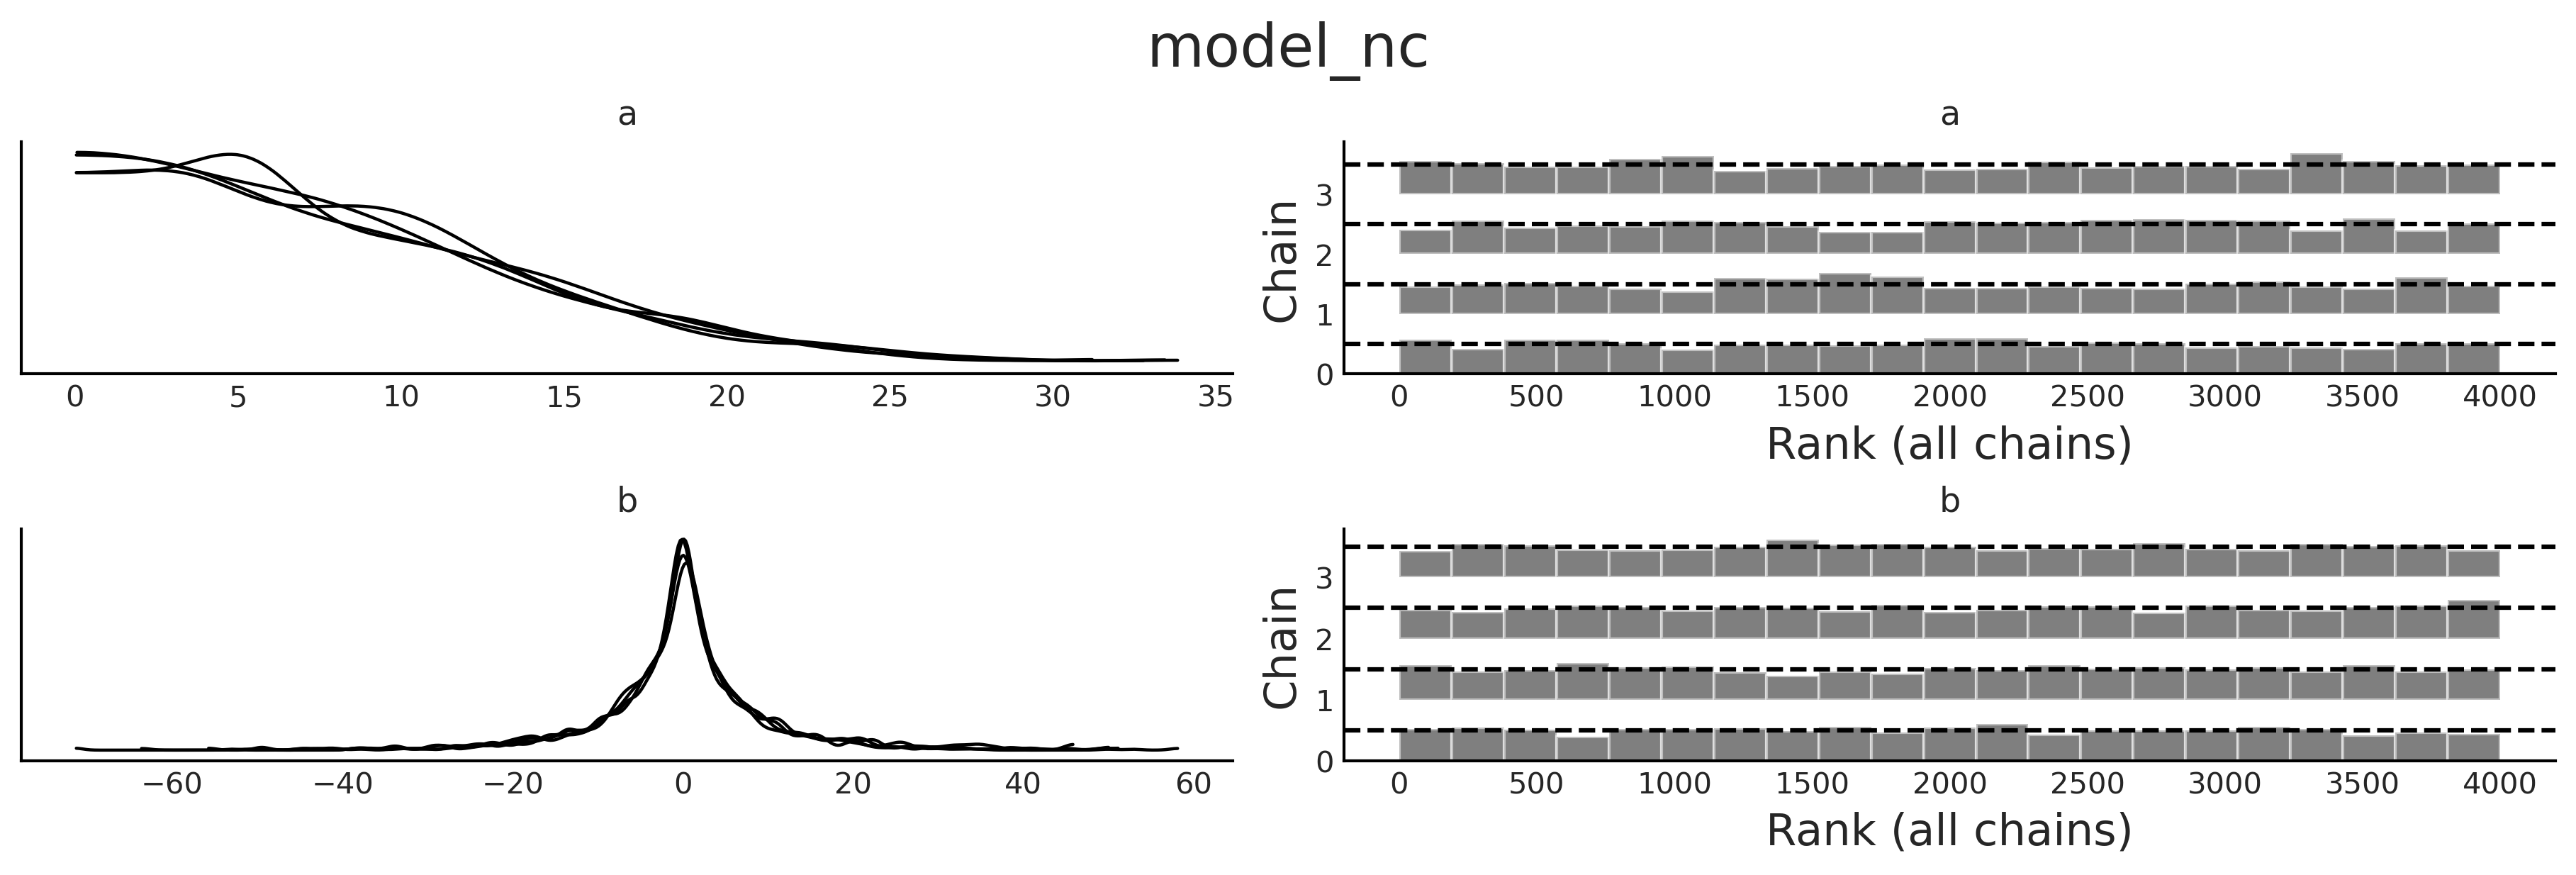

In [15]:
ax = az.plot_trace(idata_ncm, var_names=['a', "b"], kind='rank_bars', coords=coords, chain_prop={"ls": "-"}, 
                   rank_kwargs={"colors": "k", "bar_kwargs": {"alpha": 0.5}})
ax[0, 0].get_figure().suptitle('model_nc', fontsize=20)
plt.savefig('../fig/rank_plot_model_nc.png')


In [16]:
az.rhat(idata_cm, var_names=['a', "b"])

<xarray.Dataset>
Dimensions:  (b_dim_0: 10)
Coordinates:
  * b_dim_0  (b_dim_0) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    a        float64 1.209
    b        (b_dim_0) float64 1.174 1.043 1.173 1.173 ... 1.175 1.187 1.175

In [17]:
az.rhat(idata_ncm, var_names=['a', "b"])

<xarray.Dataset>
Dimensions:  (b_dim_0: 10)
Coordinates:
  * b_dim_0  (b_dim_0) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    a        float64 1.0
    b        (b_dim_0) float64 0.9999 1.001 1.001 1.0 ... 1.0 1.001 0.9995

In [18]:
az.ess(idata_cm, var_names=['a', "b"])

<xarray.Dataset>
Dimensions:  (b_dim_0: 10)
Coordinates:
  * b_dim_0  (b_dim_0) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    a        float64 14.05
    b        (b_dim_0) float64 3.395e+03 3.893e+03 ... 4.249e+03 4.973e+03

In [19]:
az.ess(idata_ncm, var_names=['a', "b"]).to_dataframe().T.round(0).astype(int)

b_dim_0,0,1,2,3,4,5,6,7,8,9
a,2918,2918,2918,2918,2918,2918,2918,2918,2918,2918
b,4100,4089,3942,3806,4171,3632,4653,3975,4092,3647


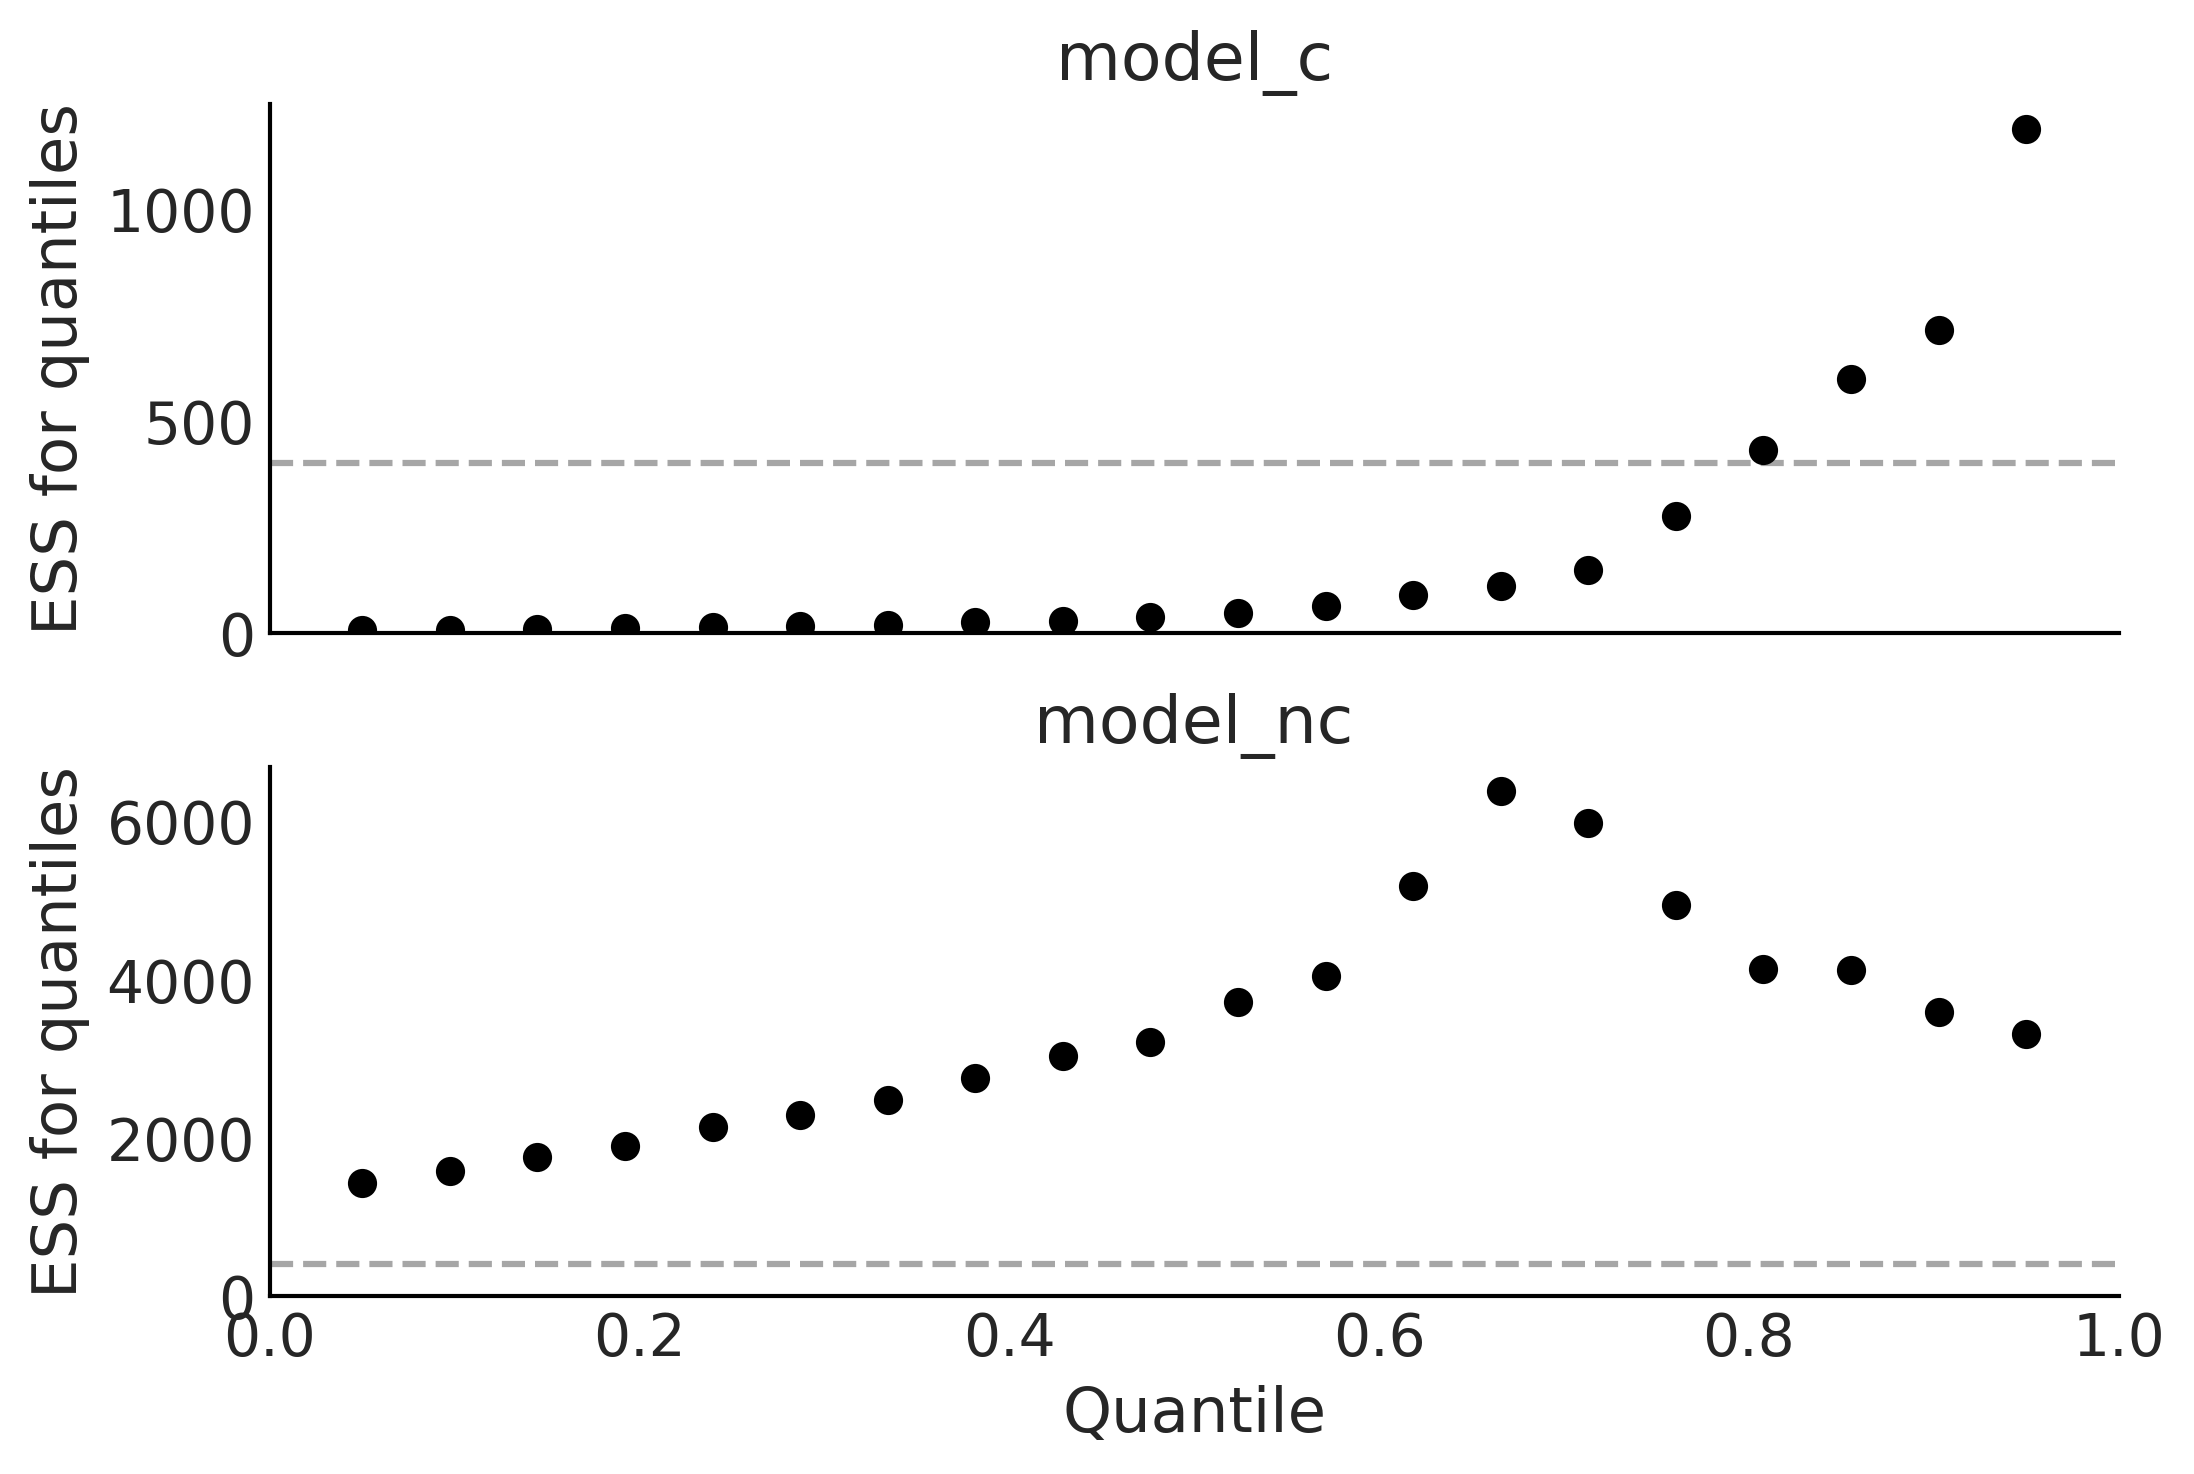

In [20]:
_, axes = plt.subplots(2, 1, sharex=True)
az.plot_ess(idata_cm, var_names="a", kind="quantile", ax=axes[0])
az.plot_ess(idata_ncm, var_names="a", kind="quantile", ax=axes[1])
axes[0].set_title("model_c")
axes[0].set_xlabel("")
axes[1].set_title("model_nc")
plt.savefig("../fig/ess_quantiles.png")

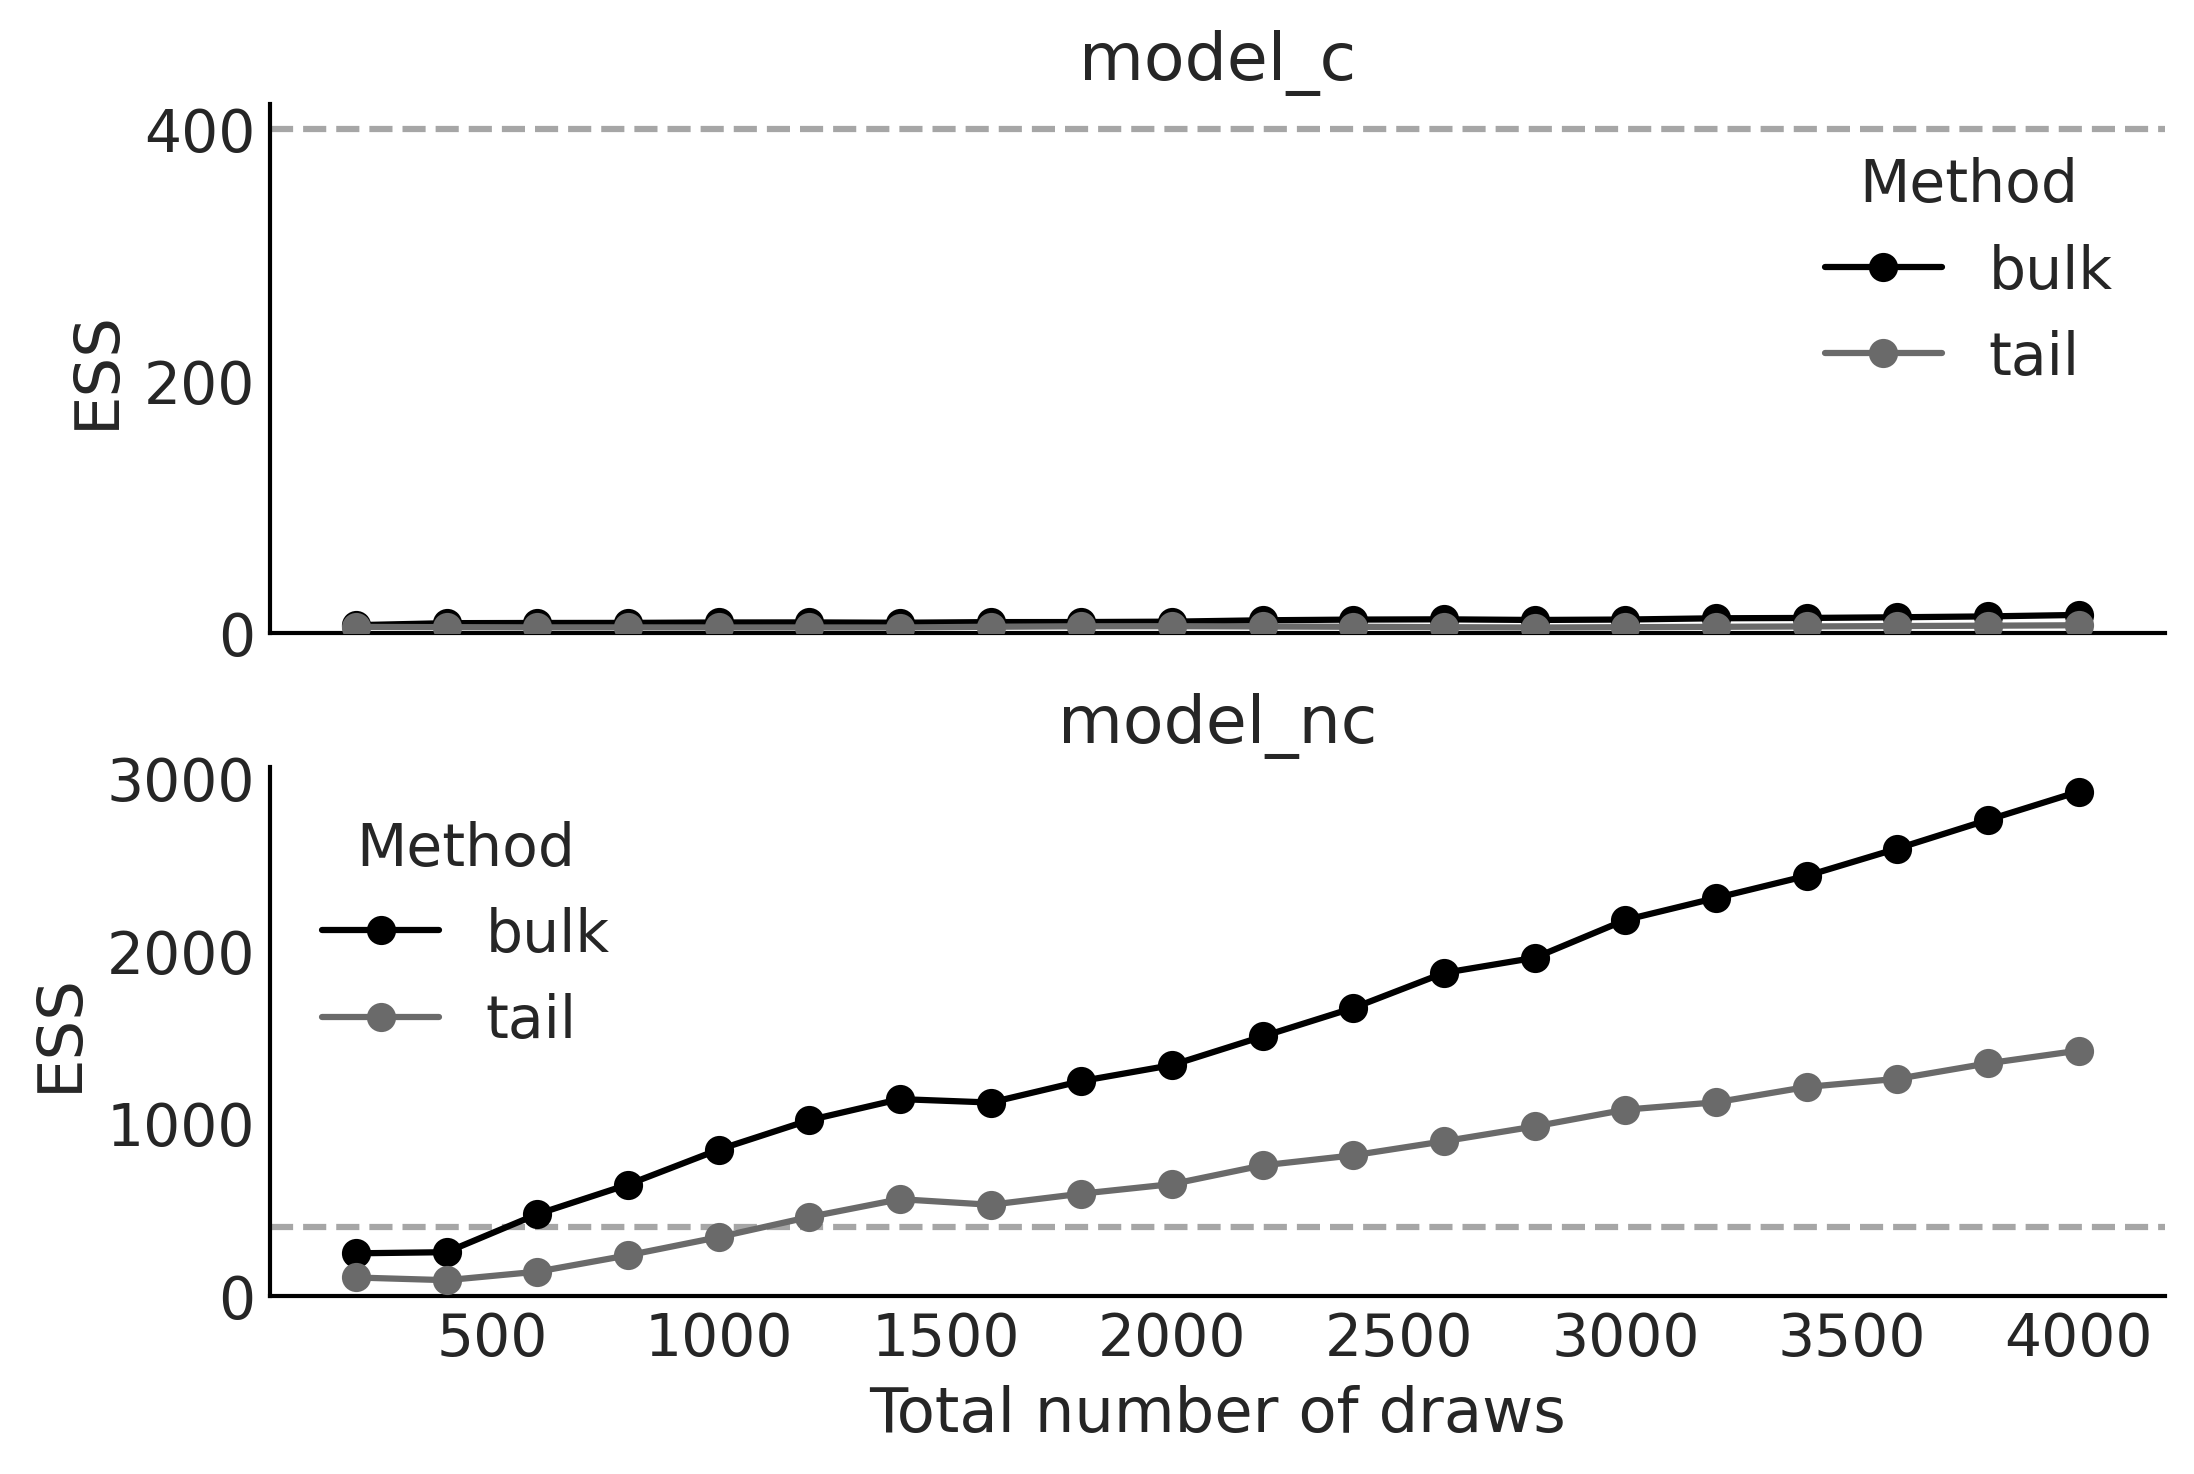

In [21]:
_, axes = plt.subplots(2, 1, sharex=True)
az.plot_ess(idata_cm, var_names="a", kind="evolution", ax=axes[0])
az.plot_ess(idata_ncm, var_names="a", kind="evolution", ax=axes[1])
axes[0].set_title("model_c")
axes[1].set_title("model_nc")
axes[0].set_xlabel("")
plt.savefig("../fig/ess_evolution.png")

## Divergences

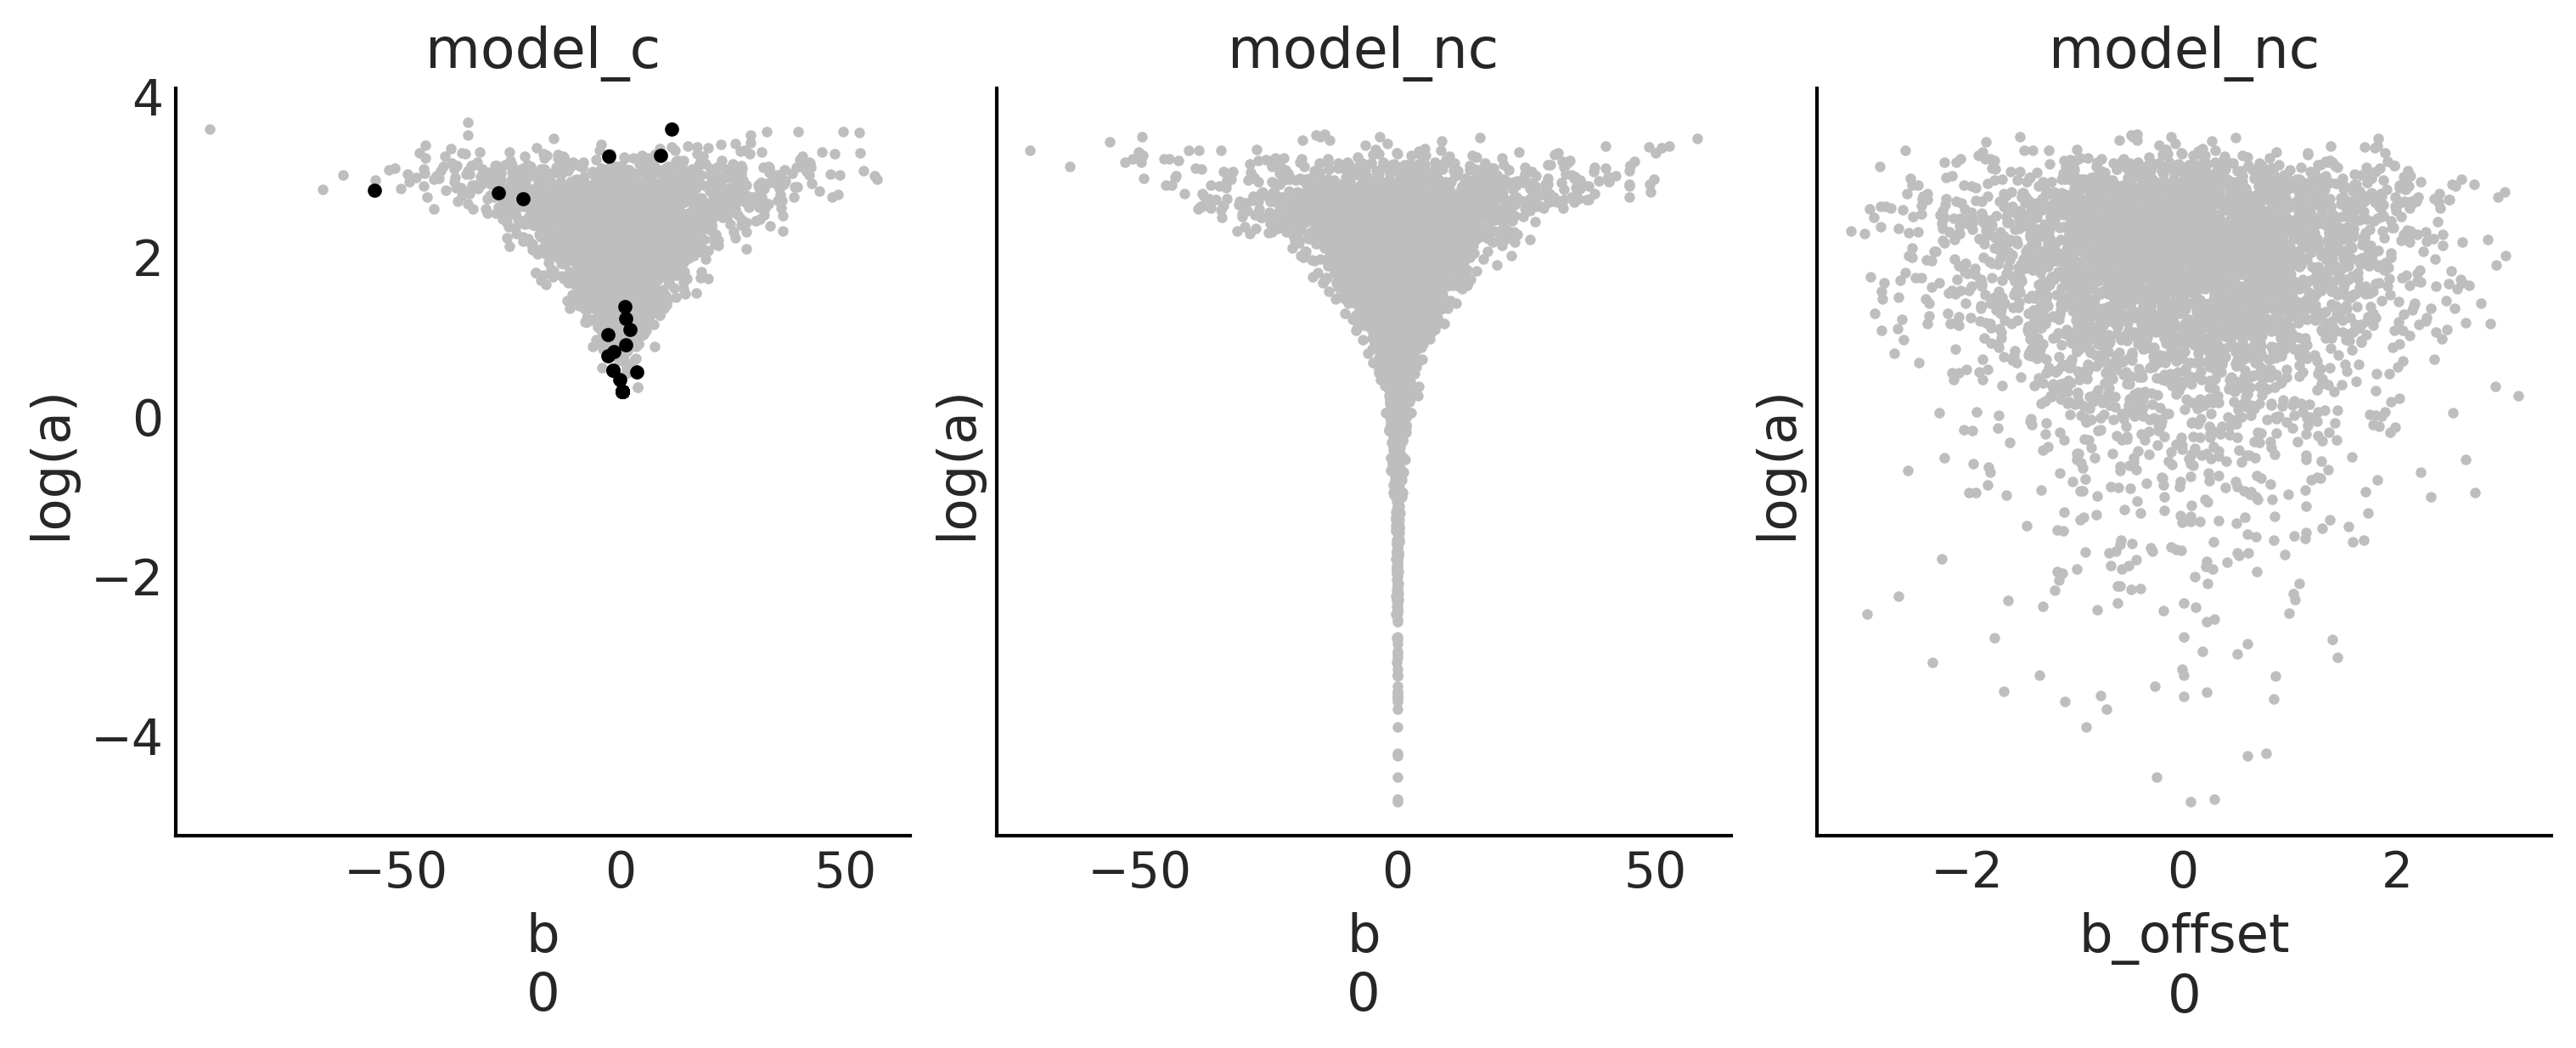

In [22]:
idata_cm.posterior["log(a)"] = np.log(idata_cm.posterior["a"])

_, axes = plt.subplots(1, 3, sharey=True, figsize=(10, 4))

az.plot_pair(
    idata_cm,
    var_names=["b", "log(a)"],
    coords={"b_dim_0": [0]},
    divergences=True,
    scatter_kwargs={"color": "C2"},
    divergences_kwargs={"color": "k", "marker": ".", "mec": None},
    ax=axes[0],
)
axes[0].set_title("model_c")

idata_ncm.posterior["log(a)"] = np.log(idata_ncm.posterior["a"])

az.plot_pair(
    idata_ncm,
    var_names=["b", "log(a)"],
    coords={"b_dim_0": [0]},
    divergences=True,
    scatter_kwargs={"color": "C2"},
    divergences_kwargs={"color": "k", "marker": ".", "mec": None},
    ax=axes[1],
)
axes[1].set_title("model_nc")

az.plot_pair(
    idata_ncm,
    var_names=["b_offset", "log(a)"],
    coords={"b_offset_dim_0": [0]},
    divergences=True,
    scatter_kwargs={"color": "C2"},
    divergences_kwargs={"color": "k", "marker": ".", "mec": None},
    ax=axes[2],
)
axes[2].set_title("model_nc")
plt.savefig("../fig/divergences.png")